# Single-View Geometry (Python)

## Usage
This code snippet provides an overall code structure and some interactive plot interfaces for the *Single-View Geometry* section of Assignment 3. In [main function](#Main-function), we outline the required functionalities step by step. Some of the functions which involves interactive plots are already provided, but [the rest](#Your-implementation) are left for you to implement.

## Package installation
- You will need [GUI backend](https://matplotlib.org/faq/usage_faq.html#what-is-a-backend) to enable interactive plots in `matplotlib`.
- In this code, we use `tkinter` package. Installation instruction can be found [here](https://anaconda.org/anaconda/tk).

# Common imports

In [21]:
######
#@title 1. Connect Colab to your google drive
######

%load_ext autoreload
%autoreload 2

from google.colab import drive
drive.mount('/content/drive')
#### change to the directory in your drive. 
%cd "/content/drive/MyDrive/MP3/Q3"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/MP3/Q3


In [22]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

from PIL import Image
import pickle

In [23]:
# % matplotlib tk

# Provided functions

In [24]:
def get_input_lines(im, min_lines=3):
    """
    Allows user to input line segments; computes centers and directions.
    Inputs:
        im: np.ndarray of shape (height, width, 3)
        min_lines: minimum number of lines required
    Returns:
        n: number of lines from input
        lines: np.ndarray of shape (3, n)
            where each column denotes the parameters of the line equation
        centers: np.ndarray of shape (3, n)
            where each column denotes the homogeneous coordinates of the centers
    """
    n = 0
    lines = np.zeros((3, 0))
    centers = np.zeros((3, 0))

    plt.figure()
    plt.axis('off')
    plt.imshow(im)
    plt.show()
    print(f'Set at least {min_lines} lines to compute vanishing point')
    print(f'The delete and backspace keys act like right clicking')
    print(f'The enter key acts like middle clicking')
    while True:
        print('Click the two endpoints, use the right button (delete and backspace keys) to undo, and use the middle button to stop input')
        clicked = plt.ginput(2, timeout=0, show_clicks=True)
        if not clicked or len(clicked) < 2:
            if n < min_lines:
                print(f'Need at least {min_lines} lines, you have {n} now')
                continue
            else:
                # Stop getting lines if number of lines is enough
                break

        # Unpack user inputs and save as homogeneous coordinates
        pt1 = np.array([clicked[0][0], clicked[0][1], 1])
        pt2 = np.array([clicked[1][0], clicked[1][1], 1])
        # Get line equation using cross product
        # Line equation: line[0] * x + line[1] * y + line[2] = 0
        line = np.cross(pt1, pt2)
        lines = np.append(lines, line.reshape((3, 1)), axis=1)
        # Get center coordinate of the line segment
        center = (pt1 + pt2) / 2
        centers = np.append(centers, center.reshape((3, 1)), axis=1)

        # Plot line segment
        plt.plot([pt1[0], pt2[0]], [pt1[1], pt2[1]], color='b')

        n += 1

    return n, lines, centers

In [25]:
def plot_lines_and_vp(ax, im, lines, vp):
    """
    Plots user-input lines and the calculated vanishing point.
    Inputs:
        im: np.ndarray of shape (height, width, 3)
        lines: np.ndarray of shape (3, n)
            where each column denotes the parameters of the line equation
        vp: np.ndarray of shape (3, )
    """
    bx1 = min(1, vp[0] / vp[2]) - 10
    bx2 = max(im.shape[1], vp[0] / vp[2]) + 10
    by1 = min(1, vp[1] / vp[2]) - 10
    by2 = max(im.shape[0], vp[1] / vp[2]) + 10
    
    ax.imshow(im)
    for i in range(lines.shape[1]):
        if lines[0, i] < lines[1, i]:
            pt1 = np.cross(np.array([1, 0, -bx1]), lines[:, i])
            pt2 = np.cross(np.array([1, 0, -bx2]), lines[:, i])
        else:
            pt1 = np.cross(np.array([0, 1, -by1]), lines[:, i])
            pt2 = np.cross(np.array([0, 1, -by2]), lines[:, i])
        pt1 = pt1 / pt1[2]
        pt2 = pt2 / pt2[2]
        ax.plot([pt1[0], pt2[0]], [pt1[1], pt2[1]], 'g')

    ax.plot(vp[0] / vp[2], vp[1] / vp[2], 'ro')
    ax.set_xlim([bx1, bx2])
    ax.set_ylim([by2, by1])

# Your implementation

In [26]:
def get_vanishing_point(n, lines):
    """
    Solves for the vanishing point using the user-input lines.
    """
    # <YOUR CODE>
    A = lines.T[:, :2]
    b = -lines.T[:, 2]
    vp = np.linalg.inv(A.T @ A) @ A.T @ b
    vp = np.append(vp, 1)
    vp /= vp[-1]
    return vp


In [27]:

def get_horizon_line(vp1, vp2):
    """
    Calculates the ground horizon line.
    """
    dirn = np.cross(vp1, vp2)
    dirn = dirn / np.linalg.norm(dirn[:2]) #normalized direction vector 
    a, b, c = dirn
    eqn_str = f'Horizon line equation is: {a:+}x {b:+}y {c:+} = 0'
    print(eqn_str)
    return dirn


In [28]:
def plot_horizon_line(v_point1, v_point2, im, ax):
    """
    Plots the horizon line.
    """
    # <YOUR CODE>
    point1 = (v_point1 / v_point1[-1])[:2]
    point2 = (v_point2 / v_point2[-1])[:2]
    ax.imshow(im)
    ax.axline(point1, point2, c='b')
    ax.plot(point1[0], point1[1], 'ro')
    ax.plot(point2[0], point2[1], 'ro')

In [29]:
from sympy import Symbol,Matrix, solve

def get_camera_parameters(vpts):
    """
    Computes the camera parameters. Hint: The SymPy package is suitable for this.
    """
    # <YOUR CODE>
    f=Symbol('f')
    u=Symbol('u')
    v=Symbol('v')
    vpt1 = Matrix(vpts[:, 0]) 
    vpt2 = Matrix(vpts[:, 1]) 
    vpt3 = Matrix(vpts[:, 2])
    k = Matrix([[f, 0, u], [0, f, v], [0, 0, 1]])
    k_inverse = k.inv()
    eq1 = vpt1.T*k_inverse.T*k_inverse*vpt2
    eq2 = vpt1.T*k_inverse.T*k_inverse*vpt3
    eq3 = vpt2.T*k_inverse.T*k_inverse*vpt3
    f,u,v = solve([eq1, eq2, eq3],  [f, u, v])[0]
    k = np.array([[f, 0, u],
                 [0, f, v],
                 [0, 0, 1]], dtype = 'float')
    return f, u, v, k

In [30]:
def get_rotation_matrix(v_points, K):
    """
    Computes the rotation matrix using the camera parameters.
    """
    # <YOUR CODE>
    R_mat = np.zeros((3, 3))
    K_inv = np.linalg.inv(K)
    for i in range(3):
        r_i = K_inv @ v_points[:, i]
        R_mat[:, i] = r_i / np.linalg.norm(r_i)
    return R_mat



In [31]:
def get_homography(R, K):
    """
    Compute homography for transforming the image into fronto-parallel 
    views along the different axes.
    """
    # <YOUR CODE>
    h_mat=K @ R @ np.linalg.inv(K)
    return h_mat

# Main function

In [32]:
im = np.asarray(Image.open('./eceb.jpg'))

# Also loads the vanishing line data if it exists in data.pickle file. 
# data.pickle is written using snippet in the next cell.
if os.path.exists('./data.pickle'):
    with open('./data.pickle', 'rb') as f:
        all_n, all_lines, all_centers = pickle.load(f)
    num_vpts = 3

In [33]:
# # Click and save the line data for vanishing points. This snippet 
# # opens up an interface for selecting points and writes them to 
# # data.pickle file. The file is over-written.

# num_vpts = 3
# all_n, all_lines, all_centers = [], [], []

# for i in range(num_vpts):
#     print(f'Getting vanishing point {i}')
    
#     # Get at least three lines from user input
#     n_i, lines_i, centers_i = get_input_lines(im)
#     all_n.append(n_i)
#     all_lines.append(lines_i)
#     all_centers.append(centers_i)

# with open('data.pickle', 'wb') as f:
#     pickle.dump([all_n, all_lines, all_centers], f)

Vanishing point 1: [-1.90978090e+03  9.40147584e+01  1.00000000e+00]
Vanishing point 2: [ 3.67963040e+03 -1.05834448e+02  1.00000000e+00]
Vanishing point 3: [2.17609378e+03 5.63397782e+03 1.00000000e+00]


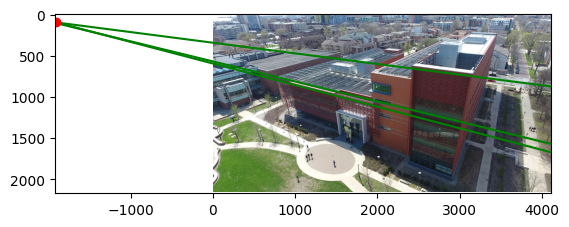

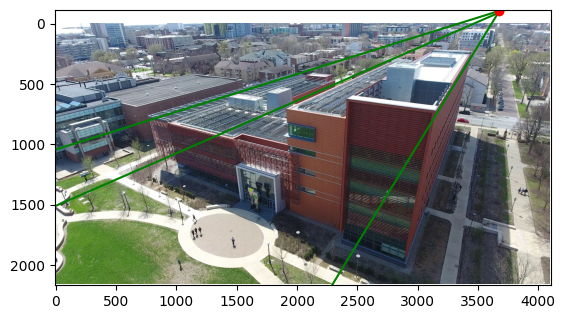

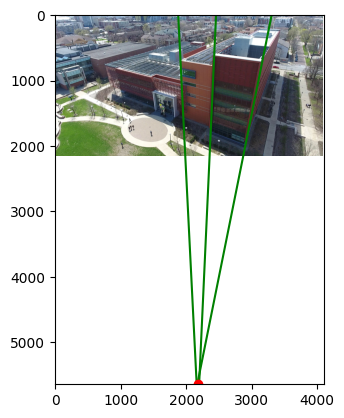

In [34]:
# Part (1)
# Computing vanishing points for each of the directions
vpts = np.zeros((3, num_vpts))

for i in range(num_vpts):
    fig = plt.figure(); ax = fig.gca()
    
    # <YOUR CODE> Solve for vanishing point
    vpts[:, i] = get_vanishing_point(all_n[i], all_lines[i])
    print("Vanishing point {}: {}".format(i+1,vpts[:, i]))
    # Plot the lines and the vanishing point
    plot_lines_and_vp(ax, im, all_lines[i], vpts[:, i])
    fig.savefig('Q3_vp{:d}.pdf'.format(i), bbox_inches='tight')
    

Horizon line equation is: +0.03573213220408763x +0.9993614034613052y -25.714177462901553 = 0


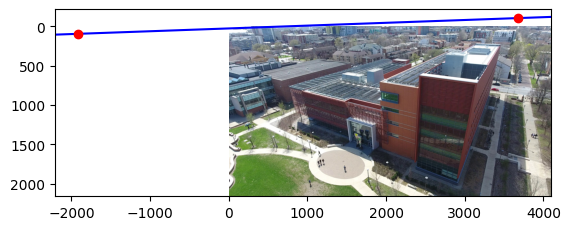

In [35]:
# Part (2) Computing and plotting the horizon
# <YOUR CODE> Get the ground horizon line
horizon_line = get_horizon_line(vpts[:, 0], vpts[:, 1])

# <YOUR CODE> Plot the ground horizon line
fig = plt.figure(); ax = fig.gca()
plot_horizon_line(vpts[:, 0], vpts[:, 1], im, ax)
fig.savefig('Q3_horizon.pdf', bbox_inches='tight')

In [36]:
!pip install sympy==1.4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [37]:
# Part (3) Computing Camera Parameters
# <YOUR CODE> Solve for the camera parameters (f, u, v)
f, u, v, K = get_camera_parameters(np.array(vpts))
print(u, v, abs(f), K)

2014.76981048735 1122.04588898287 2295.98139703213 [[-2.29598140e+03  0.00000000e+00  2.01476981e+03]
 [ 0.00000000e+00 -2.29598140e+03  1.12204589e+03]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [38]:
# Part (4) Computing Rotation Matrices
# <YOUR CODE> Solve for the rotation matrix
R = get_rotation_matrix(vpts, K)
print(R)

[[ 0.84188993 -0.53870855 -0.0318502 ]
 [ 0.22053201  0.39731233 -0.89079097]
 [ 0.49253119  0.74292396  0.45329573]]


In [39]:
homo = get_homography(R, K)
print(np.linalg.inv(homo))


[[ 8.69839124e-01  1.00221898e+00 -3.09461719e+03]
 [-5.23143363e-01  8.32641790e-01 -1.07736982e+03]
 [ 1.38721507e-05  3.87978303e-04 -9.98291798e-03]]


In [40]:
print(get_homography(np.linalg.inv(R), K))

[[ 8.69839124e-01  1.00221898e+00 -3.09461719e+03]
 [-5.23143363e-01  8.32641790e-01 -1.07736982e+03]
 [ 1.38721507e-05  3.87978303e-04 -9.98291798e-03]]
